# IMDB API + Random Forests

# Problem Statement
I've been hired by Netflix to determine what factors influence a movie's overall rating from users. In order to do this, we'll have to analyze certain factors like a movie's gross, the year it came out, and its length, and compare those factors to the existing ratings for movies. However, we want to predict how an individual user will rate a movie based on how they feel about that movie. In order to do this I'll have to obtain reviews that users write for certain movies, and identify common adjectives used to describe movies with different ratings. If we can identify these common descriptors, we can then potentially predict how a movie will be rated depending on what adjectives users are employing to describe these movies.


First, let's import the packages we'll be using.

In [1]:
# Imports at the top
import json
import urllib
import pandas as pd
import numpy as np
import requests
import re
from imdbpie import Imdb

import nltk
from nltk.tokenize import RegexpTokenizer
import collections
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

from IPython.display import Image
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Data

I gathered data that provides information of 348 movies from IMDB. The movies are from the Top 250 movies evr rated and the Bottom 100 movies rated ever. There are two movies that I will eventually drop because a lot of basic information is missing for some reason. In addition to their rating that will be imported from IMDB, I will also create a binary classification for each movie in order to identify them as good or bad.

The scraping process has been confined to a separate file in this project folder, and commented out so as to avoid the long run time or each cell. Instead, the end result of the scraping was an assembled dataframe, which was saved and read back in as a .csv file, which is our starting point. The variables of that .csv file are decribed in greater detail below.

After scraping the reviews, I used the Natural Language Tool Kit library for tokenizing each word in all reviews gathered, and then gathered a count of the 50 most common adjectives used to describe movies from imdb's Top and Bottom 100 lists. I then ran a count for each word over each movie.

In [2]:
# Read in our dataframe assembled with the web scraper.

movies = pd.read_csv('../../assets/06-project6-assets/data/movies.csv')

# Change necessary columns to integers so we can perform certain operations with them later on.

movies['imdbVotes'] = movies['imdbVotes'].astype(int)

movies.iloc[:,8:] = movies.iloc[:,8:].astype(int)

Variable | Description | Variable Type
--|--|--
imdbID | Unique ID number given to each movie in the imdb.com database | Object
movieType | A binary classification for a movie; 0 = imdbRating <= 3; 1 = imdbRating >3. If we were comparing all movies then we would use a different threshold, but since we're only comparing movies in the Top 250 and Bottom 100, we know that none of the Bottom 100 movies are rated higher than a 2.9 | Integer
title | The title for that particular movie | Object
year | The year the movie was released to theaters | Integer
runtime | The length of the movie, in minutes | Float
imdbVotes | The total number of votes that were cast for that particular movie to be in its respective list of either the Top 250 of Bottom 100 | Integer
imdbRating | Represents the average rating for a movie, on a scale of 1 to 10 | Float
gross | This represents the total gross for that movie while it was in theaters. Any missing values were converted to the mean. Nearly all of the Top 250 had this record, but several of the Worst 100 did not | Float
descriptors | From the 8th index on, there are 100 adjectives, half of which were most common in thousands of imdb.com user reviews for the Top 250 movies ever. The other half were the most common in reviews for the Bottom 100 rated movies ever | Integer

# Further Info

Before I continue, it's important to emphasize that the descriptors we chose were pulled from user reviews, and not paid film critics, so any rating predictions or type classifications are representative of IMDB users.

Second, we are assuming here that IMDB users took the time to sign up and write a review in order to describe the movie itself. However, there is the chance that a user is describing something else with one of these adjectives and not necessarily the movie. For example, one of the reviews for Raiders of the Lost Ark uses the word 'best,' but actually uses it to describe one of the movie's sequels, 'The Last Crusade.' Similarly, a user wrote the word 'terrible' in a review for The Godfather, but was actually describing a scene of violence in the movie as terrible, not the movie itself. Because of this, it's important to take any predicted rating or classification based on descriptors with a grain of salt.

# Building Regression Model

First, we'll build a regression model on our data, as we want to predict what a movie's rating will be based on the sentiment of imdb users.

In [3]:
# define X (features) and y (response)

X = movies.drop(['imdbID','movieType','title','imdbRating'], axis = 1)
y = movies.imdbRating

In [7]:
# Scale year, runtime, and gross columns to values between 0 and 1. Our minimum will now be 0 and max will be 1

X['year'] = MinMaxScaler().fit_transform(X.year.astype(float).reshape(-1,1))
X['runtime'] = MinMaxScaler().fit_transform(X.runtime.astype(float).reshape(-1,1))
X['gross'] = MinMaxScaler().fit_transform(X.gross.astype(float).reshape(-1,1))
X['imdbVotes'] = MinMaxScaler().fit_transform(X.gross.astype(float).reshape(-1,1))

When building our decision tree, we need to identify the maximum depth for our tree. Basically, this means we want to specify how many questions our model will "ask" of our data. We want to find the depth that will provide us with the best score.

In [8]:
X.head()

,year,runtime,imdbVotes,gross,bad,good,other,worst,first,more,...,special.1,acting.1,main.1,final,funny.1,important,emotional,simple,later,entire.1
0,0.978947,0.199248,0.013967,0.013967,0,1,1,0,1,1,...,1,1,1,0,1,1,1,1,1,0
1,0.347368,0.575188,0.000276,0.000276,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
2,0.631579,0.229323,0.258766,0.258766,1,1,1,0,1,1,...,1,1,1,1,0,1,0,1,1,1
3,0.378947,0.402256,0.029030,0.029030,1,1,1,0,1,1,...,1,0,1,1,1,1,0,1,1,1
4,0.957895,0.334586,0.665447,0.665447,0,1,1,0,1,1,...,1,1,1,1,0,1,1,1,1,1


Best score: 3.11274856151
Best depth: 3


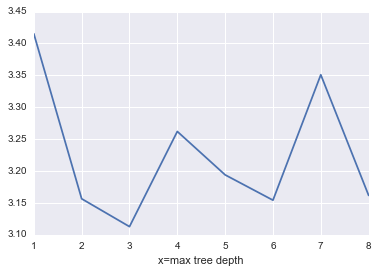

In [9]:
# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)#why 42?

# use cross-validation to find best max_depth
all_scores = []
best_score = -1
best_depth = 0
for i in range(1, 9):
    treereg = DecisionTreeRegressor(max_depth=i, random_state=1)
    scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
    current_score = np.mean(np.sqrt(-scores))
    # If the score mean is better than the current best, or best is the default (-1), then update!
    if current_score < best_score or best_score == -1:
        best_score = current_score
        best_depth = i
    # store to plot anyway!
    all_scores.append(current_score)
    
print "Best score: %s" % best_score
print "Best depth: %s" % best_depth

# import class, instantiate estimator, fit with training set
treereg = DecisionTreeRegressor(max_depth=best_depth, random_state=1)
treereg.fit(X_train, y_train)
preds = treereg.predict(X_test)

plt.figure()
plt.plot(range(1, 9), all_scores)
plt.xlabel('x=max tree depth')

So now we know that the best depth to use for our decision tree is 7, which we'll specify when we build the regressor we'll use.

Model's r^2 score: 0.797741059173


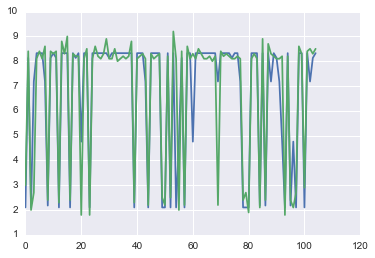

In [10]:
# print predictions and actual values

print "Model's r^2 score: %s" % r2_score(y_test, preds)
plt.plot(preds)
plt.plot(y_test.values)

The first thing we notice by plotting our predicted values versus the actual values is that the lines generally follow the same path.

It looks erratic, and that's because of the great disparity in movie ratings within our data. We didn't pull evenly from a range movies rated between 1 and 10, but pulled exclusively from movies that were either below a 3 or above an 8. So, whenever our model guesses wrong, it guesses way wrong, usually predicting a movie with a low score to be very high, and vice versa.

## Regression Model - Feature Importance

By generating our feature importance, we can see that, when determining a movie's IMDB Rating on a scale of 1 to 10, the number of votes cast for that movie are the best indicator, accounting for 84% of determining a movie's score.

In [11]:
# compute the "Gini importance" of each feature: the (normalized) total reduction of MSE brought by that feature

featureImport = pd.DataFrame({'feature':X.columns, 'importance':treereg.feature_importances_})
featureImport = featureImport.sort_values(by=['importance'], ascending=[False])

featureImport.head()

,feature,importance
2,imdbVotes,0.602445
20,awful,0.299129
37,poor,0.046339
11,many,0.040856
79,brilliant,0.011041


## Regression Decision Tree

Now that we have our regressor tree, let's visualize the decision process for our model. Keep in mind the features above that the model considers important.

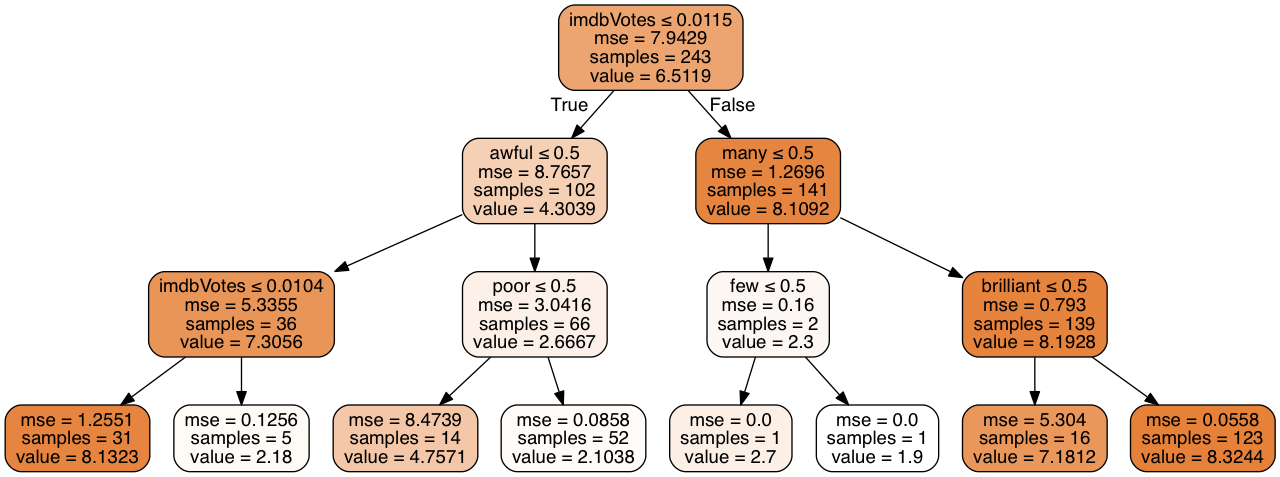

In [12]:
dot_data = StringIO()  
export_graphviz(treereg, out_file=dot_data,  
                feature_names=X.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

Let's track a single movie's score determination through the tree. I'll choose the movies all the way on the right, that were determined to have a rating of 8.9 and 8.8.

Note that when determining a movie's rating, our model first splits the movies based on the number of votes they have. If a movie has more than 25,000 votes, the model splits those movies on votes, again. At this level, our model splits the remaining movies based on whether they have more or less than 90,000 votes. If any of those movies have less than 90,000 votes, the model asks if the movies were ever described as 'important.' The movies we're looking at had more than 90,000 votes, so we go to the bran on the right.

At this point, our movies are grouped with 149 others. The model splits these based on total votes as well. Since our movies have more than 7771,800 votes, it goes to the right again, for yet another split on number of votes. Rembmer, the number of votes is the most important feature in our model, by far.

At this branch in the tree, our movies are in a bucket with 23 others, and they have more than 1.16 million votes. along with 4 other movies. The model checks the gross for each movie while it was in theaters, Remember that the gross is normalized with the minimum gross set to 0 and the max set to 1. Our movies grossed over 0.03, so the model checks whether or not a movie has been described wth the word 'worth,' and then 'worst.'

Two movies were not described using the word 'worst,' and they both had an IDMB Rating of 8.9. The other 2 did have the adjective 'worst' in at least one of their reviews, and they received a score of 8.8.


## Optimizing Regression Model with Ensemble

Above, we ran a loop to find the optimal maxmum depth for our decision tree, and determined that it was 7. However, there are many more parameters than just max_depth. With Grid Search, we can generate a regression model that finds the optimal setting for *all* parameters.

In [13]:
# Initiate GridSearch - it just may be that it's not max_depth that will get us the best model, but a certain
# combination of the model's possible parameters

PARAMETERS = {'max_depth':[1,2,3,4,5,6], 'max_features':[1,2,3,4], 
              'max_leaf_nodes':[5,6,7,8,9,10], 'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[1,2,3,4]}
SCORING = 'mean_squared_error'

In [14]:
# Grid Search

model = DecisionTreeRegressor()
clf = GridSearchCV(model, PARAMETERS, scoring=SCORING, n_jobs=-1)
clf.fit(X, y)

#After completion, show the final best results and scores
print clf.best_estimator_ #This is the regressor model we should use because parameters are optimal
print clf.best_score_
print np.sqrt(-clf.best_score_)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=4,
           max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
-11.4782980759
3.3879637064


It's great that we have a regression model, but in order to avoid overfit, we want to generalize our model. We can do this with some ensemble techniques, starting with a Random Forest Regressor.

The random forest model will essentially create a bunch of regressor models, and fit each of them to a different subset of the training data, and fit them with a random subset of variables, creating diversity in each tree. This should generalize our model, improving our accuracy.

In [15]:
cv=KFold(len(y), shuffle=False)
dt = DecisionTreeRegressor(random_state=5)
dtScore = cross_val_score(dt, X,y, cv=cv)

In [16]:
rf = RandomForestRegressor(random_state=5)
rfScore = cross_val_score(rf, X,y, cv=cv)
rfScore
print "The decision tree regressor's score was", dtScore.mean()
print "The random forest regressor's score was", rfScore.mean()

The decision tree regressor's score was -63.2638664481
The random forest regressor's score was -16.5407703056


So right away we see a great improvement in accuracy, but it's still not great.

Another way we can try and generalize is with boosting. An AdaBoost regressor will try and create a group of very simple decision trees one after another. Each tree will try and predict the movie's rating. The movie ratings that tree gets wrong now become the primary focus for the following tree, and so on and so forth for each successive tree. This essentially forces each tree to compensate for the weaknesses of its peers.

In [17]:
ab = AdaBoostRegressor(random_state=5)

abScore = cross_val_score(ab, X,y, cv=cv)
abScore
print "The decision tree regressor's score was", dtScore.mean()
print "The random forest regressor's score was", rfScore.mean()
print "The adaboost regressor's score was", abScore.mean()

The decision tree regressor's score was -63.2638664481
The random forest regressor's score was -16.5407703056
The adaboost regressor's score was -8.20843195272


And we again improve our model's score with this ensemble technique.

In [18]:
def do_plot(model, m=None, x=None):
    for fold, color in zip(cv, ['r', 'g', 'b']):
        X_train = X.iloc[fold[0]]
        X_test = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        plt.rcParams['figure.figsize']=17,8
        plt.scatter(y_test, y_pred, color = color)
        plt.plot([0.5,9.5],[0.5,9.5])
        plt.text(4.5,9, "R2: "+str(m), fontsize=14)
        plt.suptitle("Model Performance: "+str(x),fontsize=30)
        plt.xlabel("\nPredicted Ratings",fontsize=20)
        plt.ylabel("Actual Ratings\n",fontsize=20)

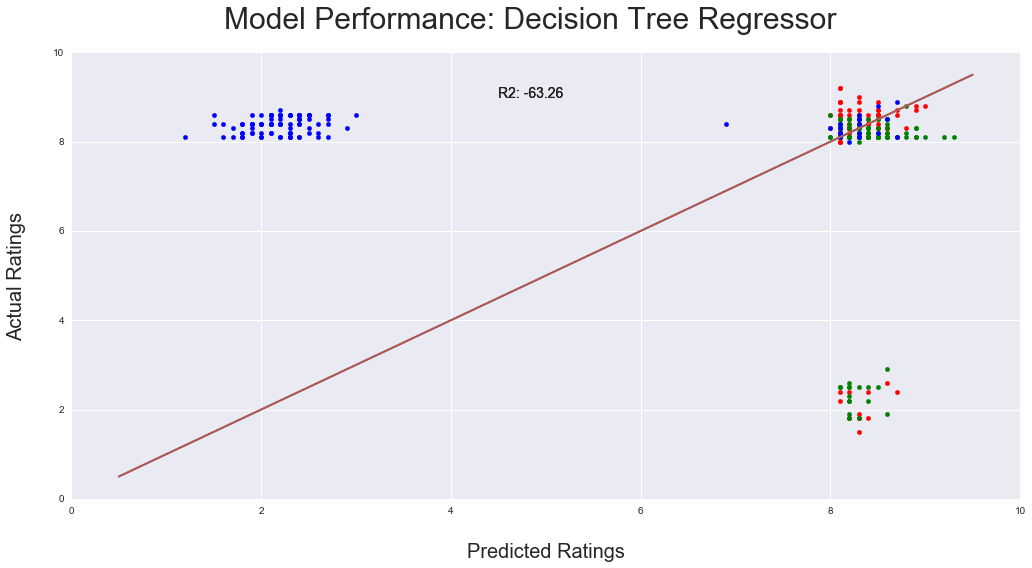

In [19]:
do_plot(dt, dtScore.mean().round(2), 'Decision Tree Regressor')

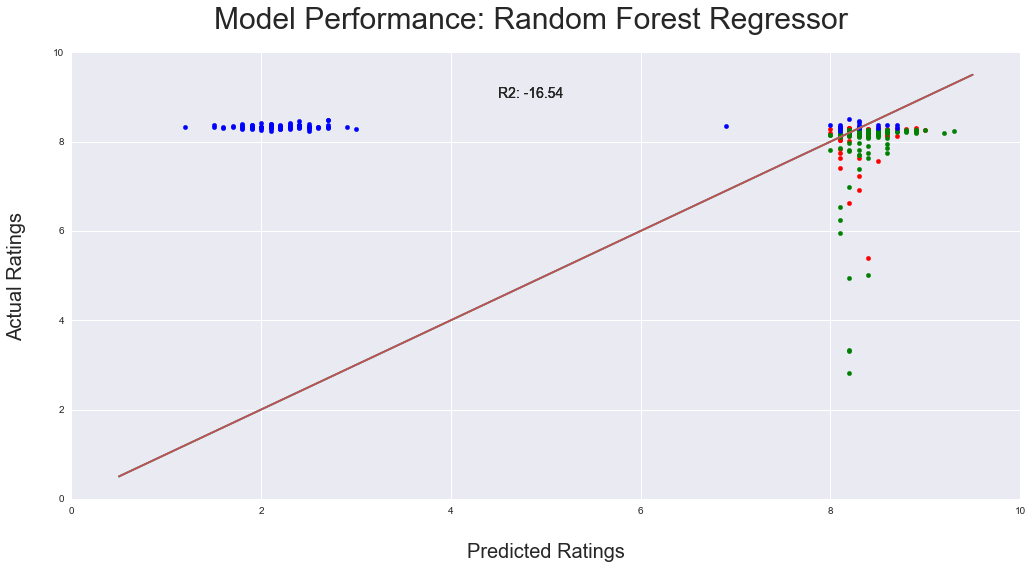

In [20]:
do_plot(ab, rfScore.mean().round(2), 'Random Forest Regressor')

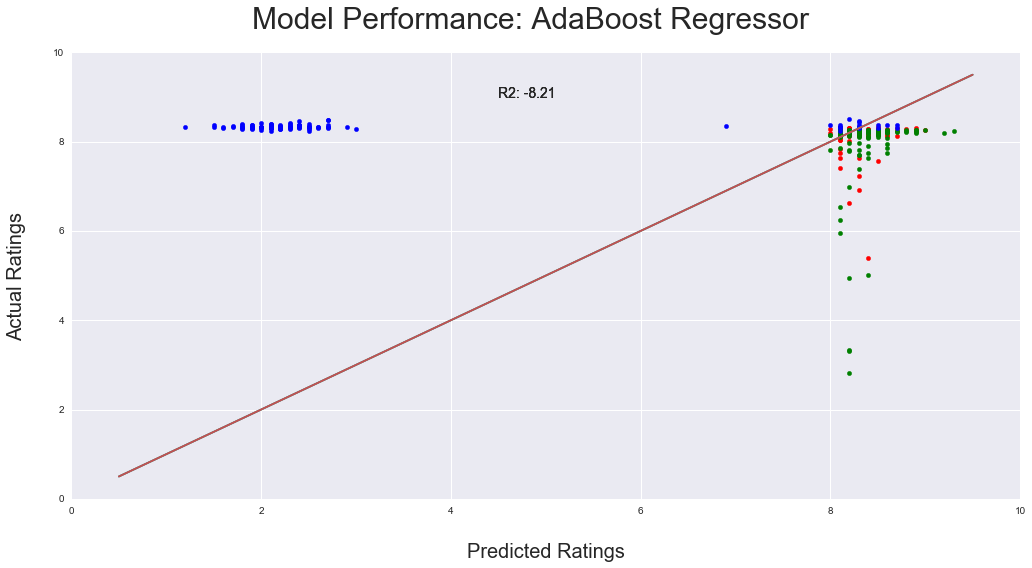

In [21]:
do_plot(ab, abScore.mean().round(2), 'AdaBoost Regressor')

We see that with each model type, we get a bit more accurate as the data fits the line a bit neater with the ensemble model using AdaBoost.

That being said, regardless of our technique there are a large number of movies that our model simply cannot get a fix on. There is a large group of highly rated movies that our model continuously predicts to have a low rating. Those movies may be much older movies that don't have a lot of votes since they're rarely seen, two parameters that are consistent with movies that usually have low ratings.

# Building Classification Model

While a regressor tree would be useful in determining a movie's rating, if we're working for Netflix, it may be more useful to build a classification model, which could make recommendations to users a bit easier. If we could figure out what factors determine whether a movie is considered Good or Bad, it would make it easier to offer suggestions to users.

Below, we'll follow a similar pattern as above, except instead of trying to determine a movie's rating on a scale of 1 to 10, we will simply try and classify a movie as good or bad.

In [22]:
# For this, we already have our features, but now we simply want to classify movies as either good or bad,
# so we just need to change y to movieType. Remember 

le = LabelEncoder()
yClass = le.fit_transform(movies['movieType'])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, yClass, test_size=0.3, random_state=42)

In [24]:
#We use Grid Search to find optimal values for each paramter
clfModel = DecisionTreeClassifier()
clf = GridSearchCV(clfModel, PARAMETERS, scoring=SCORING, n_jobs=-1)
clf.fit(X, yClass)

#After completion, show the final best results and scores
print clf.best_estimator_
print clf.best_score_
print np.sqrt(-clf.best_score_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=4, max_leaf_nodes=10, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
-0.0833333333333
0.288675134595


In [25]:
# GridSearch provides us with the optimal parameters, so we fit our model with those parameters

treeclf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=3, max_leaf_nodes=7, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=3, max_leaf_nodes=7, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

## Classification Model - Feature Importance

Note that GridSearch told us the optimal value for random_state is None forour model. The random_state parameter controls the randomness of the parameters our model chooses to make splits. If set to None, the model will generate different values each time. For the sake of having meaningful analysis, I set the random state to 1 so the results are the same every time. This will ensure my analysis is related to the actual results the model produces.

With this model, we produce the importance of our features and see that whether or not a movie is described as 'worse' accounts for 29% of a particular movie's classification. Other words like 'young,' 'big,' 'main,' and 'same' also matter, but, just as with our regressor model, the number of votes cast for a movie have the greatest impact on its classification

Note that some our features have changed with our classification model. Since we're trying to differentiate between a good or bad movie, the year or runtime don't matter as much. The violin plots below the feature table visualize the difficulty in using variables like votes, year, or runtime in the classification model.

In [26]:
# compute the feature importances

pd.DataFrame({'Feature':X.columns,
              'Importance':treeclf.feature_importances_}).sort_values('Importance', ascending=False).head(6)

,Feature,Importance
2,imdbVotes,0.524985
44,worse,0.373767
67,much.1,0.060088
40,main,0.023266
96,final,0.009587
14,same,0.008307


Notice from the distribution of votes across our two movie types, that there isn't a lot of overlap between the number of votes for good movies and for bad movies. This means there is a solid separating line for good and bad movies based on their votes.

The same does not apply, however, for year or runtime. Notice how the distributiosn for each almost perfectly overlap, especially for year of release. This means that if our model looked at those parameters, it wouldn't be able to determine if a movie was good or bad, because both good and bad movies fall within the same range of runtime and year of release.

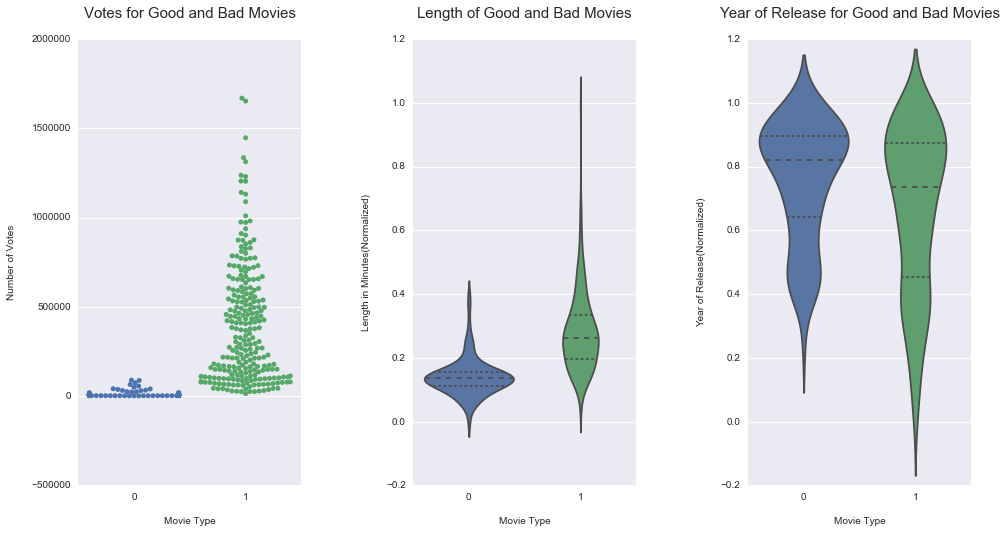

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

sns.set_style('whitegrid')
a = sns.swarmplot(x="movieType", y="imdbVotes", data=movies, ax=ax1)
ax1.axes.set_title("Votes for Good and Bad Movies\n",fontsize=15)
ax1.set_xlabel("\nMovie Type",fontsize=10)
ax1.set_ylabel("Number of Votes\n",fontsize=10)

b = sns.violinplot(x=movies['movieType'], y=X['runtime'], inner="quartile", ax=ax2)
ax2.axes.set_title("Length of Good and Bad Movies\n",fontsize=15)
ax2.set_xlabel("\nMovie Type",fontsize=10)
ax2.set_ylabel("Length in Minutes(Normalized)\n",fontsize=10)

c = sns.violinplot(x=movies['movieType'], y=X['year'], inner="quartile", ax=ax3)
ax3.axes.set_title("Year of Release for Good and Bad Movies\n",fontsize=15)
ax3.set_xlabel("\nMovie Type",fontsize=10)
ax3.set_ylabel("Year of Release(Normalized)\n",fontsize=10)

## Classification Decision Tree

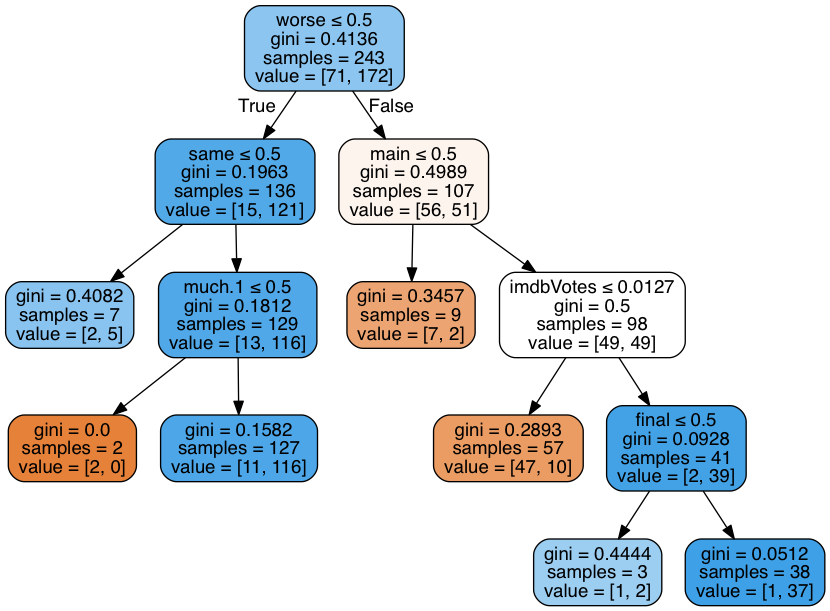

In [28]:
dot_data = StringIO()  
export_graphviz(treeclf, out_file=dot_data,  
                feature_names=X.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

The tree above is a nice visual representation for how our model is using the features to approach classification with our training data. From our feature importance above, we know there were only 6 features that had any impact on classifying movies as good or bad, so at each branch it's making a decision for a movie based on whether or not one of those features. 

The value parameter in each box represents the number of samples (movies) existing at that spot in the decision tree, with the first value representing the number of movies classified as 0, or bad, and the second number representing the amount of movies classified as 1, or good. 

Let's walk through how our model makes decisions by following the path for movies in the orange box at the bottom left, with a value set to [2,0], meaning 2 bad movies, and 0 good movies

The first decision the tree makes is based on whether or not a movie is ever described with the word 'worse.' If a movie is NOT described as worse in any of its reviews, the classifier checks to see if the remaining movies are ever described as 'same.' If not, it checks to see if the remaining movies have ever been classified as 'young.' At this point, there are 7 movies that have met all of these criteria. Of those seven movies, our model notices a clear split between them: those that have been described as 'young,' and those that have not.

Our 2 movies were not described as 'young,' so they are both classified as bad, while the other 5 were described as 'young,' and therefore classified as good. Since 100% of the values are in a single class at this point in the tree, there's no purpose in creating another split, so the model stops there for those movies. In the other cells, notice that 100% of the movies aren't in one classification. That means the model couldn't find another split at that point for those movies, so it stops there.

The gini score at the top represents the purity level of the samples. This ranges from 0.0 to 0.5, with 0.0 representing perfect purity, meaning the samples we have at this point all belong to a single class. If we look at the levels above our final branch, their gini scores are close to 0.5, meaning that if our tree were to stop at that level, it wouldn't really know how to classify the movies it has at that point, and the model would essentially split them evenly between the two classes. This is why it was so essential to run GridSearch and obtain the optimal parameters, ensuring that our model extends deep enough to properly classify, but not probe so much that it will overfit to our existing data.

In [29]:
# predict class labels for the test set

predicted = treeclf.predict(X_test)

# generate class probabilities - this will be useful for our confusion plot below

probs = treeclf.predict_proba(X_test)

probDf = pd.DataFrame(probs, columns=['probBad', 'probGood'])

probDf['actual'] = y_test

probDf.head()

,probBad,probGood,actual
0,0.824561,0.175439,0
1,0.086614,0.913386,1
2,0.777778,0.222222,0
3,0.333333,0.666667,0
4,0.086614,0.913386,1


# Model Evaluation

In [30]:
# generate evaluation metrics
print "Accuracy score is", metrics.accuracy_score(y_test, predicted)
print "Area under the curve is", metrics.roc_auc_score(y_test, probs[:, 1])

Accuracy score is 0.87619047619
Area under the curve is 0.887049659202


As we can see, our model is pretty accurate when classifying a movie as good or bad. We'll break that score into more particulars in the classification report below.

The Receiver Operating Characteristic curve plots the model's False Positive Rate against its True Positive Rate at a variety of thresholds, resulting in the blue curve below.

The area under the curve represents our model's ability to differentiate between good and bad movies. A terrible moel would have an area of 0.5, meaning it's as useful as a random guess between the two classes. Our model is 33 percentage points better than a random guess.

## Receiver Operating Characteristic

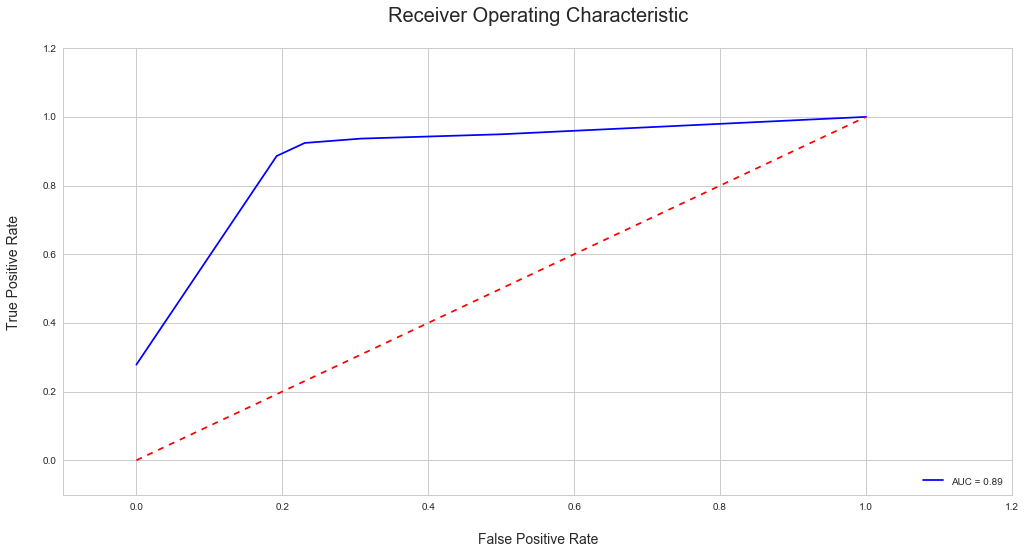

In [31]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs[:, 1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

plt.rcParams['figure.figsize']=17,8
plt.title('Receiver Operating Characteristic\n', fontsize=20)
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate\n', fontsize=14)
plt.xlabel('\nFalse Positive Rate', fontsize=14)
plt.show()

## Classification Report

In [32]:
print metrics.classification_report(y_test, predicted)

             precision    recall  f1-score   support

          0       0.78      0.69      0.73        26
          1       0.90      0.94      0.92        79

avg / total       0.87      0.88      0.87       105



Our model's precision is our model's rate of accurate predictions for a particular classification, so our model was accurate 90% of the time when it predicted a movie was bad (0).

Our model's recall is its rate of correctly labeling all of the movies in that classification. So of all the movies that were bad, our model labeled 69% of them correctly, which isn't very good, and implies that our model isn't great at classifying bad movies. Our model's recall for good movies, however, was excellent. Of the 79 good movies our model tested, it correctly classified 97% of them. This disparity means there were a lot of bad movies that our classifier incorrectly labeled as bad, which is why our model's precision for good movies was only 91%, only slightly better than that for bad movies.

The f1-score is a weighted average of the precision and recall that represents our model's ability to accurately predict each classification relative to the other classification. Our classifications are 0 for "Bad," and 1 for "Good," so our model is 78% accurate when predicting that a movie will be bad, while it's 94% accurate when predicting that a movie will be good.

## Confusion Matrix

In [33]:
print confusion_matrix(y_test, predicted)

[[18  8]
 [ 5 74]]


Our model's initial confusion matrix distributes our predicted values into False Positives, False Negatives, True Positives, and True Negatives. 

A False Positive means our model predicted the movie would be good, or Positive. However, in reality, that particular movie was bad, so our prediction was false.

A False Negative is the opposite of that: our model predicted a movie would be bad, but we were wrong - the movie was actually one of the good ones.

The visuals below provide more detail than this simple grid.

In [34]:
# First we need to create a table that has the probability value for a Good classification beside
# the actual classification for that movie

cmDf = probDf[['actual', 'probGood']]
threshold = 0.5

# In order to show the different classes each falls into within the confusion matrix, we need
# another column that tells us the classification type within the matrix, so we can color code them in the plot.

def predLabel(row):
    if row['probGood'] >= threshold and row['actual'] == 1:
        return "TP"
    elif row['probGood'] >= threshold and row['actual'] == 0:
        return "FP"
    elif row['probGood'] < threshold and row['actual'] == 1:
        return "FN"
    else:
        return "TN"

# Apply the function above to create the column

cmDf['predVal'] = cmDf.apply (lambda row: predLabel (row),axis=1)

#This is what we see for each movie in the test set

cmDf.head()

,actual,probGood,predVal
0,0,0.175439,TN
1,1,0.913386,TP
2,0,0.222222,TN
3,0,0.666667,FP
4,1,0.913386,TP


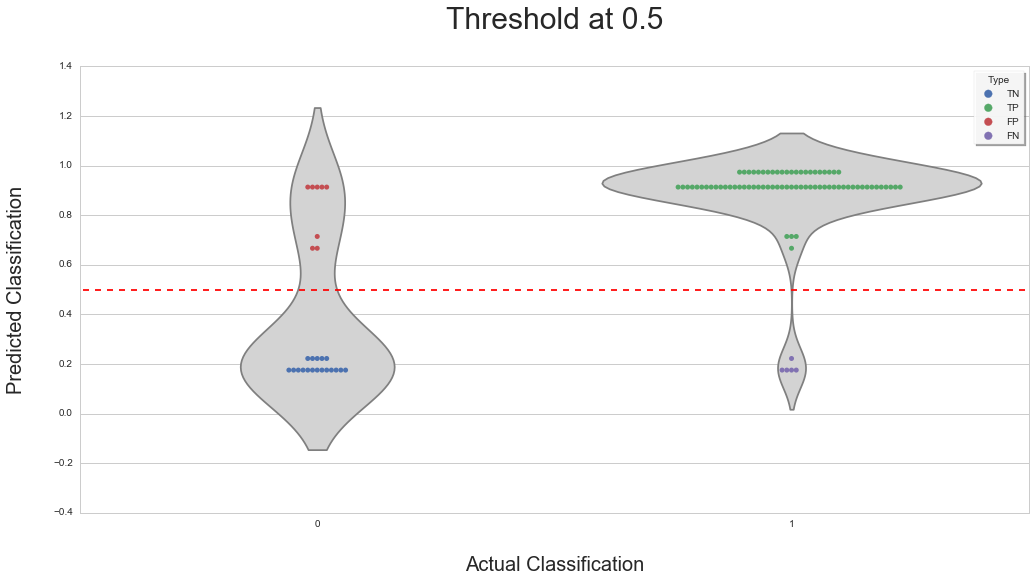

In [35]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=17,8
ax = sns.violinplot(x="actual", y="probGood", data=cmDf, inner=None, color="lightgray")
ax = sns.swarmplot(x="actual", y="probGood", hue="predVal", data=cmDf, edgecolor="gray")
ax.axes.set_title("Threshold at 0.5\n",fontsize=30)
ax.set_xlabel("\nActual Classification",fontsize=20)
ax.set_ylabel("Predicted Classification\n",fontsize=20)
ax.legend(title="Type", frameon=True, shadow=True, framealpha=0.9)
plt.plot([-1,2],[0.5,0.5],'r--')

This allows us to more easily see the distribution of our movies within the classifications. The x-axis tells us which movies were, in reality, bad or good. The y-axis tells us the probabilty each movie has in the test set of being a good movie. We set a threshold - represented by the dashed red line - of 0.5, meaning if a movie has a 50% or higher probabilty of being a good movie, then it's predicted to be a good movie. Anything lower than 50%, and our model decides it's a bad movie.

Overall, our classifer looks pretty solid in its ability to differentiate between a good movie and a bad movie. We know this because of how far each actual classification is from the threshold. Our model is especially good at classifying good movies, as we can see from the large amount of True Positives that are at or above a 90% probabilty for being a good movie.

In [36]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."

    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)
    
    # Set xlabels
    ax.set_xlabel('Predicted Results', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('Actual Results', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)
    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

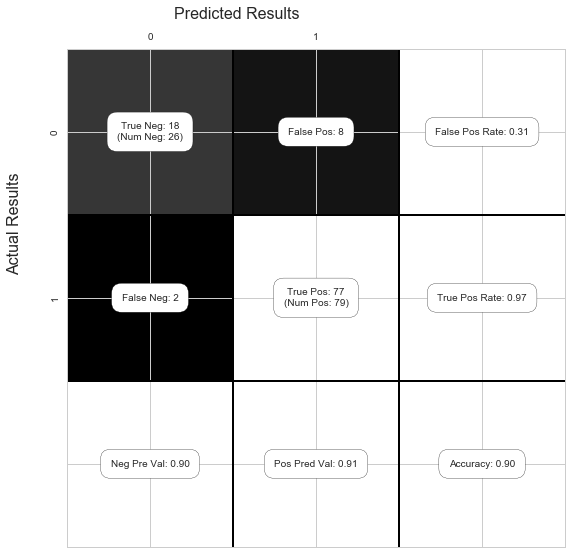

In [37]:
# plots confusion matrix onto the ridiculous plot made in the function above

C = confusion_matrix(y_test, treeclf.predict(X_test))
show_confusion_matrix(C, ['0', '1'])

Our confusion matrix gave us a True Positive Rate of 0.97, meaning that 97% of the time our model predicted a movie would be good, and each time it actually was good. Our False Positive Rate of 0.31 tells us when a movie is actually bad, our model will mistakenly predict that they will be good 31% of the time.

It would be interesting to check the number of votes for those bad movies that were classified as good, because they all had the same high probabilty as our True Positives (good movies that were classified as good). With votes being the highest consideration, it is likely that these bad movies were still popular.

Overall, our model was accurate in 90% of its predictions, which isn't that bad.

# Conclusions

   * We can predict whether or not a movie will be good or bad based on popular adjectives users have in their reviews, with some accuracy. However, 90% isn't exactly wonderful, considering there was an enormous disparity in ratings between what was good and what was bad. A bad movie in this case wasn't just bad, but it was the worst of the worst in human history, while a good movie was one of the classics, and our model's tendency to classify a movie as good probably stems from the fact that the vast majority of movies in our dataset were already very good. The model would benefit from a greater representation of bad movies.
   
   * Our model's ability to accurately classify movies depends heavily on the presence of a single word in one of its reviews we pulled. This means our model has no idea how to classify a movie like The Godfather if a user failed to describe it with the word 'classic.' On the otherhand, if Attack of the Jurassic Shark, or Santa Claus Conquers the Martians were described as 'classic,' they would be described as better than The Godfather. This is not optimal.
   
   * Our model could be more useful if we could dig deeper into the descriptors we chose, by ensuring the descriptors were adjectives describing the movie itself. We simply pulled adjectives, which means that if a person, in their review, described the restaurant they attended before going to the movie as 'classic,' then the model will think the movie itself was described as classic.
   
   * This method could be useful if, combined with the point above, we were able to classify movies as good or bad for particular users, and not overall. For example, if we could look at users, as well as movies, and find the adjectives a particular user uses for movies they watch, then we can tailor a classification for that user. This would be helpful, since some people prefer movies like Boggy Creek III: And the Legend Continues over 3 hour experimental dramas like Citizen Kane. This is why choosing individual user ratings would be mroe useful, as it avoids the problem of having unrelated adjectives, and it would also let us tailor a classification to that user's preferences.